In [1]:
# !pip install torch torchvision torchaudio
# !pip install torch-tensorrt -f https://download.pytorch.org/whl/cu124
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install opencv-python

In [2]:
# !nvcc --version
# !nvidia-smi
# !which python

References:

https://www.youtube.com/watch?v=TU5BMU6iYZ0&ab_channel=NVIDIADeveloper



In [3]:
# Download Coco validation dataset to ./huggingface/datasets/coco (it's smaller)
# !wget http://images.cocodataset.org/zips/val2017.zip
# !mkdir -p ./datasets/coco
# !unzip val2017.zip -d ./datasets/coco
# !rm val2017.zip

In [4]:
import gc
import os
import time
import torch
import cv2
import torch_tensorrt
import torchvision
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights

Unable to import quantization op. Please install modelopt library (https://github.com/NVIDIA/TensorRT-Model-Optimizer?tab=readme-ov-file#installation) to add support for compiling quantized models
TensorRT-LLM is not installed. Please install TensorRT-LLM or set TRTLLM_PLUGINS_PATH to the directory containing libnvinfer_plugin_tensorrt_llm.so to use converters for torch.distributed ops


[02/25/2025-17:11:20] [TRT] [W] Functionality provided through tensorrt.plugin module is experimental.


In [5]:
# Configurations
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "torchvision.models"
MODEL_VARIANT = "resnet18"
IMAGE_DIR = "val2017"
IMAGE_NUMS = 128  # Number of images to test
BATCH_SIZE = 16  # Adjust based on GPU memory
NUM_TRIALS = 10
DYNAMIC_BATCH_ENABLED = True
DATA_DIR = "./datasets/coco/val2017/"
INPUT_SIZE = (3, 224, 224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

torch._dynamo.config.automatic_dynamic_shapes = (
    True  # Ensure dynamic shape handling is enabled
)

In [6]:
class CocoDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (INPUT_SIZE[1], INPUT_SIZE[2]))
        image = image.transpose((2, 0, 1))  # W, H, C => C, H, W
        image = torch.from_numpy(image).float() / 255.0  # Normalize to [0,1]

        # Normalize using ImageNet mean and std
        mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
        std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
        image = (image - mean) / std
        return image

In [7]:
def load_pytorch():
    """Load model in PyTorch Eager mode."""
    model = (
        torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        .to(DEVICE)
        .eval()
    )
    return model

In [8]:
def load_pytorch_compile():
    """Load model optimized with `torch.compile`."""
    model = load_pytorch()
    return torch.compile(model=model, backend="inductor")

In [9]:
def load_tensorrt_pytorch():
    model = load_pytorch()
    example_input = torch.randn((BATCH_SIZE, 3, 224, 224)).to(DEVICE)
    optimized_model = torch.compile(model, backend="tensorrt")
    optimized_model(example_input)  # compiled on first run
    return optimized_model


def load_tensorrt():
    model = load_pytorch()
    example_input = torch.randn((BATCH_SIZE, 3, 224, 224)).to(DEVICE)
    trt_model = torch_tensorrt.compile(
        model,
        ir="dynamo",
        inputs=[
            torch_tensorrt.Input(
                min_shape=(1, 3, 224, 224),
                opt_shape=(BATCH_SIZE // 2, 3, 224, 224),
                max_shape=(BATCH_SIZE, 3, 224, 224),
                dtype=torch.float32,
            )
        ],
    )

    return trt_model

In [10]:
def clear_gpu_memory():
    gc.collect()  # Run garbage collection to remove unreferenced tensors
    torch.cuda.empty_cache()  # Empty unused GPU memory

In [ ]:
def benchmark_inference(model, dataloader, method="pytorch", runs=NUM_TRIALS):
    latencies = []
    torch.cuda.synchronize()

    # Warm-up runs
    with torch.no_grad():
        for _ in range(3):
            for images in dataloader:
                images = images.to(
                    DEVICE, non_blocking=True if images.is_pinned() else False
                )  # Non-blocking to overlap data transfer and computation
                model(images)

    # Timed runs
    for _ in range(runs):
        start = time.perf_counter()
        with torch.no_grad():
            for images in dataloader:
                images = images.to(DEVICE, non_blocking=True)
                model(images)
        torch.cuda.synchronize()
        end = time.perf_counter()
        latencies.append(end - start)

    avg_latency = sum(latencies) / runs
    throughput = IMAGE_NUMS / avg_latency  # Images per second
    return avg_latency, throughput

# Prepare Dataset

In [ ]:
image_paths = [os.path.join(DATA_DIR, img) for img in os.listdir(DATA_DIR)][:IMAGE_NUMS]
dataset = CocoDataset(image_paths)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

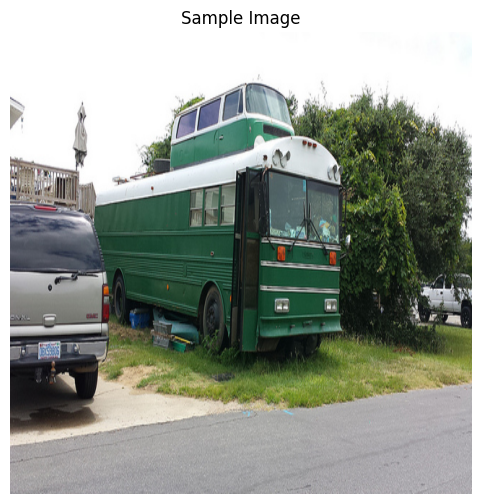

In [13]:
# Read and preprocess the image
image = cv2.imread(image_paths[0])
if image is None:
    print(f"Error: Failed to load image - {image_paths[0]}")
else:
    # Convert BGR to RGB (OpenCV loads in BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to 640x640
    image = cv2.resize(image, (640, 640))

    # Display using Matplotlib
    plt.figure(figsize=(6, 6))  # Optional: Adjust figure size
    plt.imshow(image)
    plt.axis("off")  # Hide axis for a cleaner look
    plt.title("Sample Image")
    plt.show()

# TensorRT:

In [14]:
# TensorRT Benchmark
clear_gpu_memory()
model_trt_pytorch = load_tensorrt_pytorch()
latency_trt_pytorch, throughput_trt_pytorch = benchmark_inference(
    model_trt_pytorch, dataloader, method="tensorrt_pytorch"
)
print(
    f"TensorRT - Avg Latency: {latency_trt_pytorch:.4f}s, Throughput: {throughput_trt_pytorch:.2f} images/sec"
)
del model_trt_pytorch

TensorRT - Avg Latency: 0.1050s, Throughput: 1218.80 images/sec


In [15]:
# TensorRT Benchmark
clear_gpu_memory()
model_trt = load_tensorrt()
latency_trt, throughput_trt = benchmark_inference(
    model_trt, dataloader, method="tensorrt"
)
print(
    f"TensorRT - Avg Latency: {latency_trt:.4f}s, Throughput: {throughput_trt:.2f} images/sec"
)
del model_trt

TensorRT - Avg Latency: 0.1056s, Throughput: 1212.49 images/sec


# Pytorch Eager Execution (Standard Pytorch):

In [16]:
clear_gpu_memory()
torch.cuda.synchronize()
model_pt = load_pytorch()
latency_pt, throughput_pt = benchmark_inference(model_pt, dataloader, method="pytorch")
print(
    f"PyTorch - Avg Latency: {latency_pt:.4f}s, Throughput: {throughput_pt:.2f} images/sec"
)
del model_pt

PyTorch - Avg Latency: 0.1147s, Throughput: 1115.95 images/sec


# PyTorch Compile:

In [17]:
clear_gpu_memory()
torch.cuda.synchronize()
model_compile = load_pytorch_compile()
latency_compile, throughput_compile = benchmark_inference(
    model_compile, dataloader, method="torch.compile"
)
print(
    f"torch.compile - Avg Latency: {latency_compile:.4f}s, Throughput: {throughput_compile:.2f} images/sec"
)
del model_compile

torch.compile - Avg Latency: 0.1075s, Throughput: 1190.60 images/sec


# Result Analysis:

In [18]:
# Speedup Comparisons
speedup_torch_compile = latency_pt / latency_compile
speedup_tensorrt = latency_pt / latency_trt
speedup_tensorrt_pytorch = latency_pt / latency_trt_pytorch

print(f"\n Speedup (torch.compile vs PyTorch): {speedup_torch_compile:.2f}x")
print(f" Speedup (TensorRT_pytorch method vs PyTorch): {speedup_tensorrt_pytorch:.2f}x")
print(f" Speedup (TensorRT vs PyTorch): {speedup_tensorrt:.2f}x")


 Speedup (torch.compile vs PyTorch): 1.07x
 Speedup (TensorRT_pytorch method vs PyTorch): 1.09x
 Speedup (TensorRT vs PyTorch): 1.09x
